## set random seed

In [1]:
import torch
torch.manual_seed(42)

In [2]:
def token(line):
    line = line.strip()
    return line.split(' ')

def preprocess(path):
    results = []
    with open(path, 'r') as f:
        for line in f:
            results.append(token(line))
    return results

In [3]:
dataset = preprocess('data/train.txt')
testDataset = preprocess('data/test.txt')

In [4]:
class Word_dict():
    def __init__(self, dataset):
        self.word_dict = {}
        self.idx_dict = {}
        self.add("<PAD>")
        self.add("<UNK>")
        self.make_dict(dataset)
        
    def make_dict(self, dataset):
        for sent in dataset:
            for word in sent:
                self.add(word)
        
    def add(self, word):
        if word not in self.word_dict:
            self.idx_dict[self.get_len()] = word
            self.word_dict[word] = self.get_len()
            
            
    def word2index(self, word):
        if word in self.word_dict:
            return self.word_dict[word]
        else:
            return self.word_dict["<UNK>"]
    
    def idx2word(self, idx):
        return self.idx_dict[idx]
    
    def get_len(self):
        return len(self.word_dict)

In [5]:
word_dict = Word_dict(dataset)
PAD_IDX = word_dict.word2index("<PAD>")
import pickle

with open('dicitonary.pkl','wb') as f:
    pickle.dump(word_dict, f)

In [6]:
def data2index(dataset):
    data = []
    for sent in dataset:
        data.append([word_dict.word2index(word) for word in sent])
    return data

In [7]:
from sklearn.model_selection import train_test_split
data = data2index(dataset)
trainData, validData = train_test_split(data, test_size=0.1, random_state=42)
testData = data2index(testDataset)

In [8]:
from torch.utils.data import Dataset
import torch

class SentenceDataset(Dataset):
    def __init__(self, data, pad_idx, training = True):
        self.data = data
        self.pad_idx = pad_idx
        self.training = training
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
        
    def collate_fn(self, datas):
        datas_idx = sorted(range(len(datas)), key=lambda x : datas[x])
        datas.sort(key=lambda x: len(x), reverse=True)
        datas_len = [len(sent) for sent in datas]
        datas = self.make_padding(datas)
        if self.training:
            return torch.LongTensor(datas), torch.LongTensor(datas_len)
        else:
            return torch.LongTensor(datas), torch.LongTensor(datas_len), datas_idx            
    
    def make_padding(self, datas):
        max_len = max([len(data) for data in datas])
        padded_sent = []
        for data in datas:
            padded_sent.append(data + [self.pad_idx]*(max_len-len(data)))
        return padded_sent

In [9]:
trainData = SentenceDataset(trainData, PAD_IDX)
validData = SentenceDataset(validData, PAD_IDX)
testData = SentenceDataset(testData, PAD_IDX, training = False)

In [31]:
for i in testData:
    print(i)

[1, 40, 341, 2548, 2190, 93, 408, 296, 2261, 1]
[2, 144, 1, 6]
[2, 1, 4, 5, 6]
[2, 1, 8, 9, 6]
[2, 1, 11, 12, 6]
[2, 1, 14, 15, 6]
[2, 1, 16, 1, 6]
[2, 1, 19, 20, 6]
[2, 1, 21, 22, 6]
[2, 1, 14, 23, 6]
[2, 1, 8, 25, 6]
[2, 1, 27, 28, 6]
[2, 1, 8, 29, 6]
[2, 1, 30, 31, 6]
[2, 1, 33, 34, 6]
[2, 1, 14, 36, 6]
[2, 1, 26, 38, 6]
[2, 1, 27, 39, 6]
[2, 1, 40, 41, 6]
[2, 1, 8, 43, 6]
[2, 1, 26, 45, 6]
[2, 1, 47, 48, 6]
[2, 1, 50, 51, 6]
[2, 1, 27, 52, 6]
[2, 1, 50, 53, 6]
[2, 1, 54, 55, 6]
[2, 1, 56, 57, 6]
[2, 1, 58, 59, 6]
[2, 1, 56, 60, 6]
[2, 1, 61, 62, 6]
[2, 1, 64, 65, 6]
[2, 1, 8, 67, 6]
[2, 1, 4, 5, 6]
[2, 1, 8, 9, 6]
[2, 1, 11, 12, 6]
[2, 1, 14, 15, 6]
[2, 1, 16, 1, 6]
[2, 1, 19, 20, 6]
[2, 1, 21, 22, 6]
[2, 1, 14, 23, 6]
[2, 1, 8, 25, 6]
[2, 1, 27, 28, 6]
[2, 1, 8, 29, 6]
[2, 1, 30, 31, 6]
[2, 1, 33, 34, 6]
[2, 1, 14, 36, 6]
[2, 1, 26, 38, 6]
[2, 1, 27, 39, 6]
[2, 1, 40, 41, 6]
[2, 1, 8, 43, 6]
[2, 1, 26, 45, 6]
[2, 1, 47, 48, 6]
[2, 1, 50, 51, 6]
[2, 1, 27, 52, 6]
[2, 1, 50, 53, 6]


## Model

In [10]:
from torch import nn

In [11]:
class Embedding(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(Embedding, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
    def forward(self, input):
        embedded = self.embedding(input)
        
        return embedded

In [12]:
from torch.nn.utils.rnn import pack_padded_sequence
class Encoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, embedding):
        super(Encoder, self).__init__()
        
        self.embedding = embedding
    
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)        
    
    def forward(self, input, data_len):
        input = self.embedding(input)
        
        pack_datas = pack_padded_sequence(input, data_len, batch_first=True)
        
        outputs, hidden = self.rnn(input)
        
        return hidden

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, embedding):
        super(Decoder, self).__init__()
        
        self.output_dim = output_dim
        
        self.embedding = embedding
        
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)

        self.out = nn.Linear(hid_dim, output_dim)
        
    def forward(self, input, hidden):
        input = self.embedding(input)
        
        output, hidden = self.rnn(input, hidden)
        
        prediction = self.out(output)
        
        return prediction, hidden

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        
        self.decoder = decoder
        
    def forward(self, src, trg, data_len, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[0]
        max_len = trg.shape[1]
        
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(batch_size, max_len - 1, trg_vocab_size).to(device)
        
        hidden = self.encoder(src, data_len)  
        
        input = trg[:, 0:1]
        
        for t in range(1, max_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:,t-1:t] = output
            
            top1 = output.argmax(2)
            
            if torch.rand(1) > teacher_forcing_ratio:
                input = top1
            else:
                input = trg[:,t:t+1]
            
        return outputs

# Training

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
INPUT_DIM = word_dict.get_len()
OUTPUT_DIM = word_dict.get_len()
EMB_DIM = 128
HID_DIM = 128

emb = Embedding(INPUT_DIM, EMB_DIM)
enc = Encoder(EMB_DIM, HID_DIM, emb)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, emb)

model = Seq2Seq(enc, dec).to(device)

In [17]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(
      (embedding): Embedding(19738, 128)
    )
    (rnn): GRU(128, 128, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(
      (embedding): Embedding(19738, 128)
    )
    (rnn): GRU(128, 128, batch_first=True)
    (out): Linear(in_features=128, out_features=19738, bias=True)
  )
)


In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,270,810 trainable parameters


In [19]:
class accuracy():
    def __init__(self):
        self.ndata = 0
        self.ncorrect = 0
    def update(self, predictions, groundTruths):
        self.ndata += len(groundTruths)
        predictions = predictions.cpu()
        groundTruths = groundTruths.cpu()
        for i in range(len(groundTruths)):
            length = int(torch.sum(groundTruths[i] != PAD_IDX))
            prediction = predictions[i][:length]
            groundTruth = groundTruths[i][:length]
            if torch.equal(prediction, groundTruth):
                self.ncorrect += 1
        
    def get_score(self):
        return self.ncorrect / self.ndata

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)

In [20]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
import json

def run_epoch(epoch, training):
    model.train(training)
    if training:
        description = 'Train'
        dataset = trainData
        shuffle = True
    else:
        description = 'Valid'
        dataset = validData
        shuffle = False
    
    dataloader = DataLoader(dataset = dataset,
                            batch_size = 32,
                            shuffle=shuffle,
                            collate_fn=dataset.collate_fn,
                            num_workers=0)
    
    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0
    acc = accuracy()
    for i, (x, data_len) in trange:
        output, batch_loss = run_iter(x, data_len, training)
        if training:
            opt.zero_grad()
            batch_loss.backward()
            opt.step()
        loss += batch_loss.item()
        acc.update(output, x)
        trange.set_postfix(loss = loss / (i + 1), acc = acc.print_score())
    if training:
        history['train'].append({'acc':acc.get_score(), 'loss':loss/ len(trange)})
    else:
        history['valid'].append({'acc':acc.get_score(), 'loss':loss/ len(trange)})
def run_iter(x, data_len, training):
    sent = x.to(device)
    if training:
        output = model(sent, sent, data_len)
    else:
        with torch.no_grad():
            output = model(sent, sent, 0)
    sent = sent[:, 1:]
    sent = sent.reshape(sent.shape[0] * sent.shape[1])
    output_sent = output.view(output.shape[0] * output.shape[1], output.shape[2])
    loss = criterion(output_sent, sent)
    return output.argmax(2), loss

def save(epoch):
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(model.state_dict(), 'model/model.pkl.'+str(epoch))
    with open('model/history.json', 'w') as f:
        json.dump(history, f, indent=4)

In [21]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size = 10, gamma = 0.5)
max_epoch = 50
history = {'train':[],'valid':[]}

In [22]:
for epoch in range(max_epoch):
    print('Epoch: {}'.format(epoch))
    run_epoch(epoch, True)
    run_epoch(epoch, False)
    scheduler.step()
    save(epoch)

Epoch: 0


KeyboardInterrupt: 

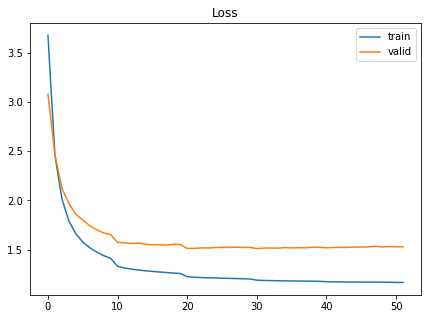

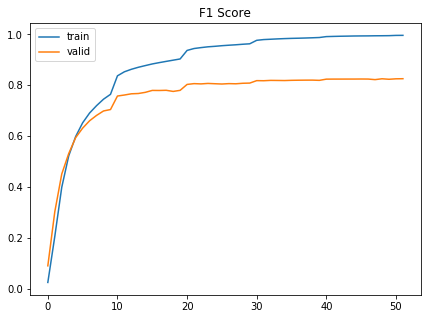

Best F1 score  [0.8254917840068967, 51]


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

with open('model/history.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['acc'] for l in history['train']]
valid_f1 = [l['acc'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['acc'], idx] for idx, l in enumerate(history['valid'])]))

In [33]:
model.load_state_dict(torch.load('model/model.pkl.{}'.format(-1)))
model.train(False)
# run_epoch(1, False)
dataloader = DataLoader(dataset=testData,
                            batch_size=32,
                            shuffle=False,
                            collate_fn=testData.collate_fn,
                            num_workers=0)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
for i, (x, data_len, data_idx) in trange:
    o_labels = model(x.to(device), data_len, 0)
    o_labels = torch.argmax(o_labels, dim = 2)
    o_labels = o_labels.to('cpu').numpy().tolist()
    for idx in datas_idx:
        prediction.append(o_labels[idx])


# prediction = sum(prediction, [])

RuntimeError: 'lengths' argument should be a 1D CPU int64 tensor

In [59]:
with open('task1.txt', 'w') as f:
    for idx, sent in enumerate(prediction):
        s = ' '
        length = len(testData[idx])
        seq = ["<SOS>"] + [word_dict.idx2word(word_idx) for word_idx in sent[:length]]
        f.writelines(s.join(seq) + '\n')